<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/Mirabest_MCD_lenet_64_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import sys
import shutil
import subprocess
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [20]:
!nvidia-smi

Mon Sep  5 22:10:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
shutil.rmtree('bnn_hmc', ignore_errors=True)

In [23]:
!git clone https://github.com/adammoss/bnn_hmc

Cloning into 'bnn_hmc'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 600 (delta 45), reused 12 (delta 4), pack-reused 531
Receiving objects: 100% (600/600), 1.10 MiB | 14.44 MiB/s, done.
Resolving deltas: 100% (426/426), done.


In [24]:
!cd bnn_hmc && git checkout dropout_wip

Branch 'dropout_wip' set up to track remote branch 'dropout_wip' from 'origin'.
Switched to a new branch 'dropout_wip'


In [25]:
# https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl
!pip install jax==0.2.12
!pip install dm-haiku==0.0.5.dev0 optax==0.0.6 chex==0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl (189.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
for i, root in enumerate(glob.glob('/content/runs/*/')):
  shutil.rmtree(root, ignore_errors=True)

In [27]:
!python3 bnn_hmc/scripts/run_sgd.py --seed=0 --weight_decay=10 --dir=runs/sgd/mirabestc/ \
--dataset_name=mirabest/confident --model_name=lenet_dropout --init_step_size=3e-7 --num_epochs=200 --eval_freq=5 \
--batch_size=53 --save_freq=5 --optimizer=SGD --train_split=train[:80%] --test_split=train[80%:] --patience 10 \
--dropout_rate 0.1 --image_size=64

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Starting from random initialization with provided seed
/content/bnn_hmc/bnn_hmc/utils/script_utils.py:153: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, test_set, key))
/content/bnn_hmc/bnn_hmc/utils/script_utils.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, train_set, key))
---  --------  ----------

In [28]:
!python3 bnn_hmc/scripts/run_sgd.py --seed=0 --weight_decay=10 --dir=runs/sgd/mirabestc/ \
--dataset_name=mirabest/confident --model_name=lenet_dropout --init_step_size=3e-7 --num_epochs=200 --eval_freq=5 \
--batch_size=53 --save_freq=5 --optimizer=SGD --eval_split=test --repeats 10 --dropout_rate 0.1 --image_size=64

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Continuing the run from the last saved checkpoint
bnn_hmc/scripts/run_sgd.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, test_set, key))
{'accuracy': DeviceArray(0.8173077, dtype=float32), 'nll': 0.37170264, 'ece': DeviceArray(0.1332449, dtype=float32)}


In [29]:
softmax = []
for i, root in enumerate(glob.glob('/content/runs/sgd/mirabestc/*/predictions*npy')):
  prediction = np.load(root)
  softmax.append(np.squeeze(prediction))
softmax = np.array(softmax)

In [30]:
def uncertainty(softmax):
  # Per example softmax with shape(num_examples, num_classes)
  predictive_entropy = 0
  single_pass_entropy = 0
  for i in range(softmax.shape[1]):
    # Sum over classes
    predictive_entropy += -np.mean(softmax[:,i])*np.log(np.mean(softmax[:,i]))
    single_pass_entropy += -softmax[:,i]*np.log(softmax[:,i])
  single_pass_entropy = np.mean(single_pass_entropy)
  mutual_info = predictive_entropy - single_pass_entropy
  return predictive_entropy, single_pass_entropy, mutual_info

In [31]:
predictive_entropies = [] 
single_pass_entropies = []
mutual_infos = []
for i in range(softmax.shape[1]):
  predictive_entropy, single_pass_entropy, mutual_info = uncertainty(softmax[:,i,:])
  predictive_entropies.append(predictive_entropy)
  single_pass_entropies.append(single_pass_entropy)
  mutual_infos.append(mutual_info)
print('Predictive entropy:', np.mean(predictive_entropies), np.std(predictive_entropies))
print('Single pass entropy:', np.mean(single_pass_entropies), np.std(single_pass_entropies))
print('Mutual info:', np.mean(mutual_infos), np.std(mutual_infos))

Predictive entropy: 0.475809407602915 0.18524258843208888
Single pass entropy: 0.4150225 0.16628912
Mutual info: 0.060786921041793764 0.04780274338542248


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


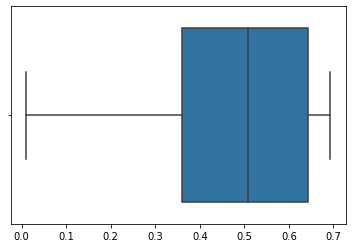

In [32]:
sns.boxplot(predictive_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


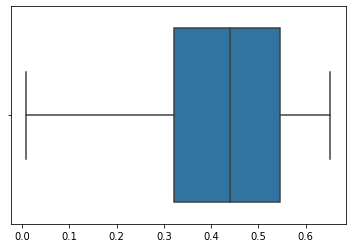

In [33]:
sns.boxplot(single_pass_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


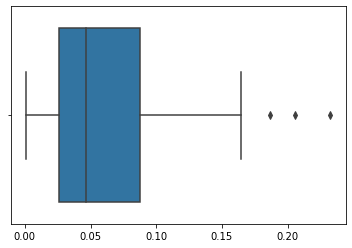

In [34]:
sns.boxplot(mutual_infos)
plt.show()